# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, top_k_accuracy_score
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import random
import pandas as pd
import math
import time

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [2]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Data Exploration

In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape} type: {type(y_train[0])}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape} type: {type(y_test[0])}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000,) type: <class 'numpy.int64'>
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000,) type: <class 'numpy.int64'>


#### General data exploration functions

In [4]:
def peek_array(arr, name="array", n_show=12, cols=6, labels=None, label_map=None):
    """Print basic stats and (if RGB images) show a grid of samples."""
    flat_nbytes = arr.nbytes / 1024 / 1024
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, "
          f"min={arr.min():.3f}, max={arr.max():.3f}, ~{flat_nbytes:.1f} MB")

cifar10_label_to_text = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
                         5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

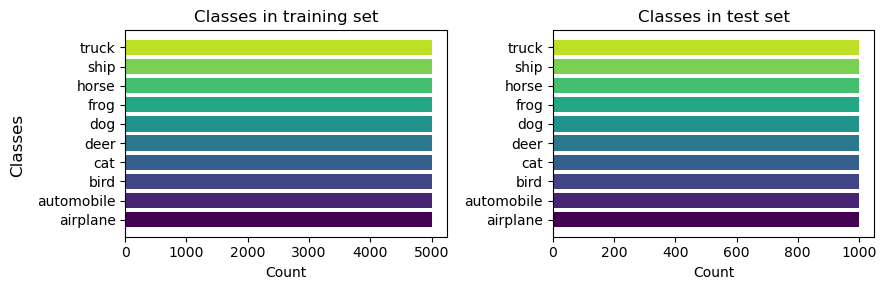

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

for i, (dataset, title) in enumerate([(y_train, 'training'), (y_test, 'test')]):
    labels, counts = np.unique(dataset, return_counts=True)
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / len(labels)) for i in range(len(labels))]
    labels_text = [cifar10_label_to_text[label] for label in labels]

    axs[i].barh(labels_text, counts, color=colors)
    axs[i].set_title(f'Classes in {title} set')
    axs[i].set_xlabel('Count')

fig.supylabel('Classes')
plt.tight_layout()

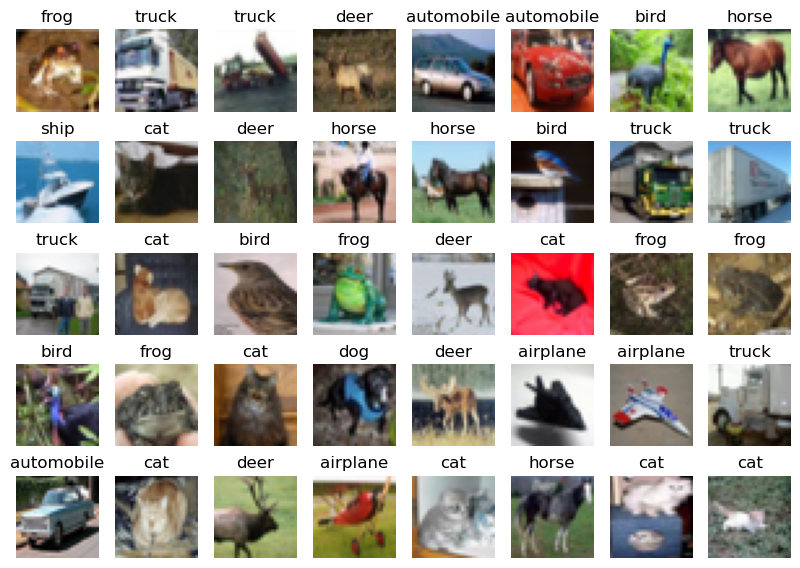

In [6]:
#X_train without preprocessing
N_ROWS = 5; N_COLS = 8
fig, axs = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(10, 7))

for i in range(N_ROWS):
    for j in range(N_COLS):
        axs[i][j].imshow(X_train[i*N_COLS+j])
        axs[i][j].axis('off')
        axs[i][j].set_title(cifar10_label_to_text[y_train[i*N_COLS+j]])

plt.show()

#### General data preprocessing for all models

In [7]:
#force the pixel values to have values in the normalized range of [0,1] ensuring that all
#pixels contribute equally to the model
def to_float01(x): 
    return (x.astype('float32') / 255.0)

#### Data Processing for Support Vector Machine 

In [10]:
def svm_data_processing(X_train, X_test):
    X_tr = to_float01(X_train); X_te = to_float01(X_test)
    X_train_flat = X_tr.reshape(len(X_tr), -1).astype(np.float32)
    X_test_flat  = X_te.reshape(len(X_te), -1).astype(np.float32)
    return X_train_flat, X_test_flat

In [11]:
X_train_svm, X_test_svm = svm_data_processing(X_train, X_test)

#### Data preprocessing for MLP Model

In [10]:
#standardize the pixel values for each RGB color channels for model optimization
#helping the gradient to converge faster
#implying removing the effect of RGB values from the value of each color and
#forcing each channel to have a near zero mean and unit variance 
def mlp_augment(image, label, seed=SEED):
    image = image + tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, seed=seed)
    image = tf.clip_by_value(image, 0.0, 1.0)  # keep in valid range
    return image, label
    
def mlp_data_processing(X_train, X_test):
    X_tr = to_float01(X_train); X_te = to_float01(X_test)
    mean = X_tr.mean(axis=(0,1,2))
    std = X_te.std(axis=(0,1,2))
    for i in range(3): 
        X_tr[..., i] = (X_tr[..., i] - mean[i]) / std[i] 
        X_te[..., i] = (X_te[..., i] - mean[i]) / std[i]

    X_train_aug, y_train_aug = mlp_augment(X_tr, y_train)
    X_train_full = np.concatenate([X_tr, X_train_aug], axis=0)
    y_train_full = np.concatenate([y_train, y_train_aug], axis=0)
    return X_train_full, y_train_full, X_te

In [11]:
X_train_mlp, y_train_mlp, X_test_mlp = mlp_data_processing(X_train, X_test)

#### Data preprocessing for CNN Model

In [23]:
AUTO = tf.data.AUTOTUNE

def augment(image, label):
    # random crop with 4px padding + horizontal flip (train only)
    image = tf.pad(image, [[4,4],[4,4],[0,0]], mode='REFLECT')
    image = tf.image.random_crop(image, size=[32,32,3], seed=SEED)
    image = tf.image.random_flip_left_right(image, seed=SEED)
    return image, label

DEFAULT_BATCH = 128  # can be overridden later

def make_datasets(X_tr, y_tr, X_val, y_val, X_te, y_te, batch_size=DEFAULT_BATCH):
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))\
        .shuffle(10000, seed=SEED, reshuffle_each_iteration=True)\
        .map(augment, num_parallel_calls=AUTO)\
        .batch(batch_size).prefetch(AUTO)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
        .batch(batch_size).cache().prefetch(AUTO)    # + cache
    test_ds  = tf.data.Dataset.from_tensor_slices((X_te,  y_te ))\
        .batch(batch_size).cache().prefetch(AUTO)    # + cache
    return train_ds, val_ds, test_ds

sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=SEED)
train_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, y_tr = X_train[train_idx], y_train[train_idx]
X_val, y_val = X_train[val_idx],  y_train[val_idx]
X_te,  y_te  = X_test,            y_test

X_tr = to_float01(X_tr); X_val = to_float01(X_val); X_te = to_float01(X_te)
train_ds, val_ds, test_ds = make_datasets(X_tr, y_tr, X_val, y_val, X_te, y_te, DEFAULT_BATCH)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

#### Image preprocessed for SVM Model

In [12]:
print("The shape of the flattened X_train images dataset ", X_train_svm.shape)

The shape of the flattened X_train images dataset  (50000, 3072)


In [13]:
pd.DataFrame(X_train_svm).head(5)

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.407843,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.533333,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.309804,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313726,0.337255,0.329412
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.149020,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.305882,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313726


#### Image preprocessed for MLP Model

First 5 images of the training set after MLP preprocessing


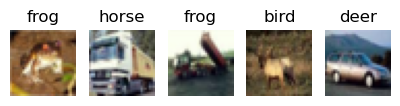

In [110]:
plt.figure(figsize=(10, 2))
print("First 5 images of the training set after MLP preprocessing")
for i in range(5):
    ax = plt.subplot(1, 10, i + 1)

    img = X_train_mlp[i]
    # Since the data is standardized (mean ~0, std ~1),
    # we rescale temporarily for visualization (to 0–1 range)
    img = (img -img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis("off")
    plt.title(cifar10_label_to_text[int(mlp_labels[i])])
plt.show()

#### Image preprocessed for CNN Model

X_train: shape=(50000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~146.5 MB


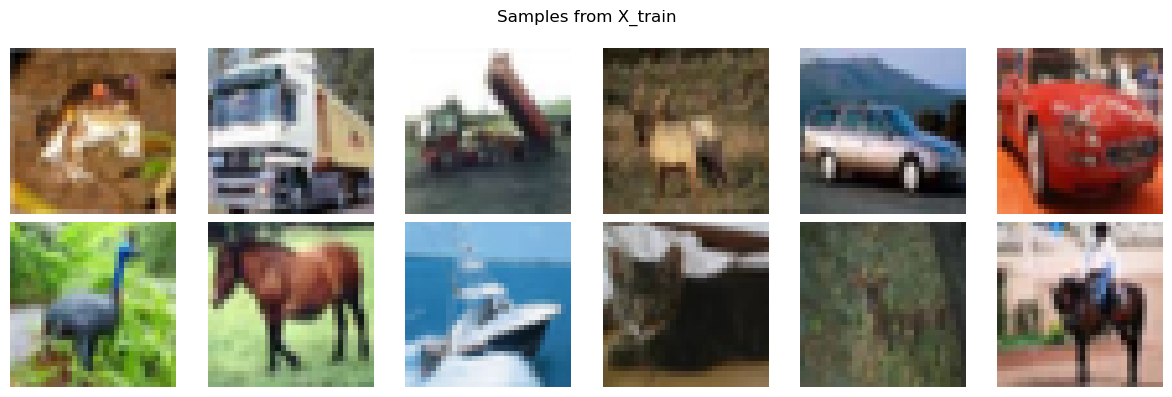

X_test: shape=(10000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~29.3 MB


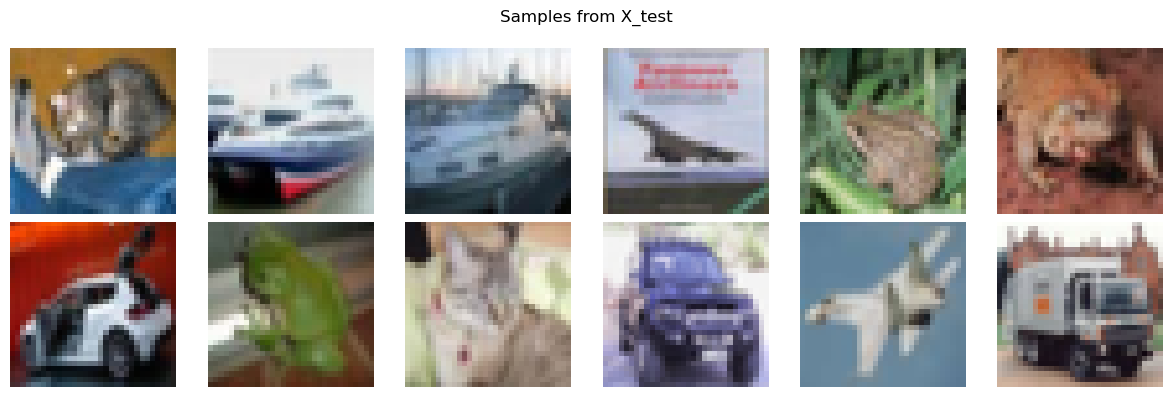

y_train: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
y_test : {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
X_train (with labels): shape=(50000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~146.5 MB


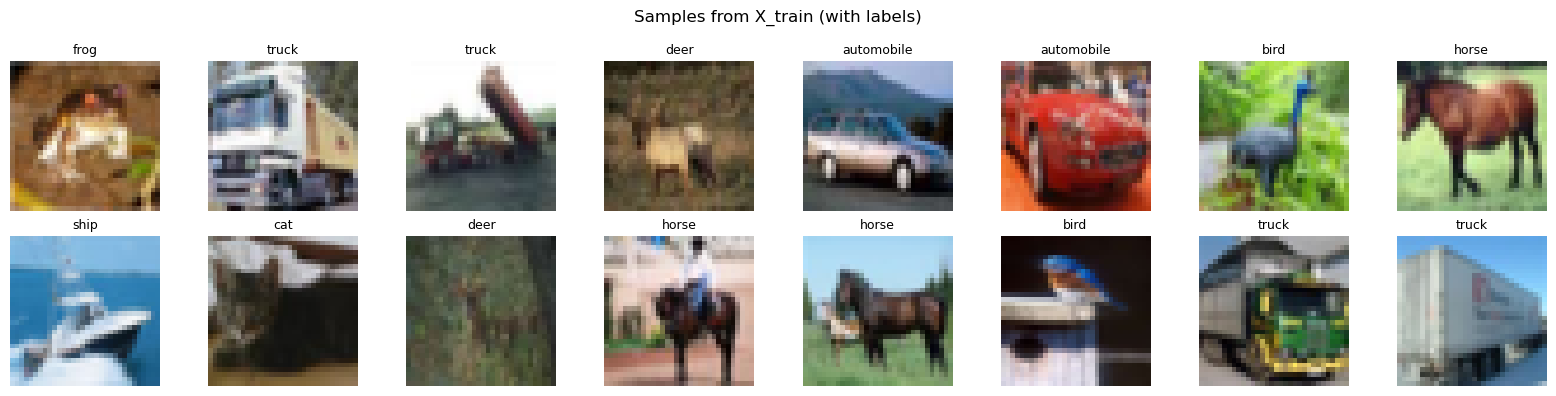

In [26]:
def peek_array(arr, name="array", n_show=12, cols=6, labels=None, label_map=None):
    """Print basic stats and (if RGB images) show a grid of samples."""
    flat_nbytes = arr.nbytes / 1024 / 1024
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, "
          f"min={arr.min():.3f}, max={arr.max():.3f}, ~{flat_nbytes:.1f} MB")

    # If looks like images: (N, H, W, 3)
    is_rgb = (arr.ndim == 4 and arr.shape[-1] in (1,3) and arr.shape[1] <= 256 and arr.shape[2] <= 256)
    if is_rgb:
        n = min(n_show, arr.shape[0])
        rows = math.ceil(n / cols)
        plt.figure(figsize=(cols*2, rows*2))
        for i in range(n):
            ax = plt.subplot(rows, cols, i+1)
            img = arr[i]
            # handle float arrays in [0,1]
            if arr.dtype.kind == "f":
                img = np.clip(img, 0.0, 1.0)
            ax.imshow(img.squeeze())
            ax.axis("off")
            if labels is not None:
                lab = labels[i]
                if label_map:
                    lab = label_map.get(int(lab), int(lab))
                ax.set_title(str(lab), fontsize=9)
        plt.suptitle(f"Samples from {name}", y=0.98)
        plt.tight_layout()
        plt.show()

peek_array(X_train, "X_train")
peek_array(X_test,  "X_test")

unique, counts = np.unique(y_train, return_counts=True)
print("y_train:", dict(zip(unique.tolist(), counts.tolist())))
unique, counts = np.unique(y_test, return_counts=True)
print("y_test :", dict(zip(unique.tolist(), counts.tolist())))

cifar10_label_to_text = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
                         5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
peek_array(X_train, "X_train (with labels)", n_show=16, cols=8,
           labels=y_train, label_map=cifar10_label_to_text)

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [14]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.8)),
    ("svc", SVC(kernel="rbf")),
])

svm_pipe.fit(X_train_svm, y_train)
y_predicted = svm_pipe.predict(X_test_svm)

In [11]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1000
           1       0.61      0.62      0.62      1000
           2       0.40      0.37      0.39      1000
           3       0.36      0.34      0.35      1000
           4       0.43      0.41      0.42      1000
           5       0.49      0.42      0.45      1000
           6       0.49      0.62      0.55      1000
           7       0.61      0.54      0.57      1000
           8       0.61      0.67      0.64      1000
           9       0.57      0.59      0.58      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000



### Fully connected neural network

In [73]:
def mlp_architecture():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(512),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(10, activation='softmax')
    ])

    learning_rate_decay = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.003,
        decay_steps=5000,
        decay_rate=0.9,
        staircase=True
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate_decay),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [75]:
model = mlp_architecture()
history = model.fit(
    X_train_mlp, y_train_mlp,
    epochs = 5, 
    validation_split=0.2,
    batch_size=128
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3306 - loss: 1.8745 - val_accuracy: 0.3944 - val_loss: 1.6657
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4442 - loss: 1.5521 - val_accuracy: 0.4586 - val_loss: 1.5222
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4801 - loss: 1.4560 - val_accuracy: 0.4757 - val_loss: 1.4642
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5042 - loss: 1.3892 - val_accuracy: 0.4990 - val_loss: 1.4260
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5243 - loss: 1.3327 - val_accuracy: 0.4952 - val_loss: 1.4239


In [76]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,223,839 (19.93 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 3,481,365 (13.28 MB)

### Convolutional neural network

In [32]:
# ==== CNN model factory (small & clear) ====
def make_cnn(filters_base=32, dropout=0.3, weight_decay=0.0):
    wd = keras.regularizers.l2(weight_decay) if weight_decay > 0 else None
    inputs = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(filters_base, 3, padding='same', use_bias=False, kernel_regularizer=wd)(inputs)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(filters_base*2, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv2D(filters_base*4, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(10, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# ==== One-pass training helper ====
def train_once(filters_base=32, dropout=0.3, weight_decay=0.0,
               lr=1e-3, batch_size=256, epochs=30, verbose=2):
    train_ds, val_ds, _ = make_datasets(X_tr, y_tr, X_val, y_val, X_te, y_te, batch_size)
    model = make_cnn(filters_base, dropout, weight_decay)
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, min_delta=0.002, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5),
    ]
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=verbose)
    elapsed = time.time() - t0
    val_acc = float(np.max(hist.history['val_accuracy']))
    return model, hist, val_acc, elapsed

# ==== Plot learning curves (acc) ====
def plot_curves(history, out_path='learning_curves_cnn.png', title='CNN Learning Curves'):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title(title)
    plt.tight_layout(); plt.savefig(out_path, dpi=180)
    plt.close()

In [ ]:
# ==== Train a baseline ====
baseline_model, baseline_hist, baseline_val_acc, baseline_time = train_once(
    filters_base=32, dropout=0.3, weight_decay=0.0,
    lr=1e-3, batch_size=256, epochs=30, verbose=2
)
print(f"[Baseline] val_acc={baseline_val_acc:.4f} | time={baseline_time/60:.1f} min | params={baseline_model.count_params()/1e6:.2f}M")

plot_curves(baseline_hist, out_path='learning_curves_cnn.png')

Epoch 1/30
176/176 - 225s - 1s/step - accuracy: 0.4212 - loss: 1.6219 - val_accuracy: 0.1066 - val_loss: 3.3170 - learning_rate: 0.0010
Epoch 2/30
176/176 - 216s - 1s/step - accuracy: 0.5177 - loss: 1.3655 - val_accuracy: 0.2352 - val_loss: 2.6830 - learning_rate: 0.0010
Epoch 3/30
176/176 - 239s - 1s/step - accuracy: 0.5482 - loss: 1.2792 - val_accuracy: 0.4782 - val_loss: 1.4069 - learning_rate: 0.0010
Epoch 4/30
176/176 - 239s - 1s/step - accuracy: 0.5748 - loss: 1.2125 - val_accuracy: 0.5590 - val_loss: 1.2458 - learning_rate: 0.0010
Epoch 5/30


## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [ ]:
param_grid = {
    "pca__n_components": [0.4, 0.8],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 1e-3, 1e-2],
}
clf_pipe = GridSearchCV(
    svm_pipe, param_grid=param_grid, cv=StratifiedKFold(shuffle=True), 
    return_train_score=True, verbose=3, n_jobs=10
)
clf_pipe.fit(X_train_svm, y_train)
y_predicted = clf_pipe.predict(X_test_svm)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
print(f"Best params: {clf_pipe.best_params_}")
print(f"Best cross-validation score: {clf_pipe.best_score_}")
print(classification_report(y_test, y_predicted))

### Fully connected neural network

In [77]:
def mlp_classifier(hp):
    model = keras.Sequential()
    try:
        model.add(keras.layers.Flatten(input_shape=(32,32,3)))
    
        layer_cnt = hp.Choice('layer_cnt', values=[2,3,4,5])
        for i in range(layer_cnt):
            uts=hp.Choice(f'node_{i}', values=[1024, 512, 256, 128])
            activation = hp.Choice(f'activation_{i}', values=['relu', 'elu', 'tanh', 'sigmoid'])
            model.add(keras.layers.Dense(units=uts))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(activation))            
            model.add(
                keras.layers.Dropout(hp.Choice(f'dropout_{i}', values=[0.1, 0.2, 0.3, 0.4]))
            )
                      
        model.add(keras.layers.Dense(10, activation='softmax'))
        ilr = hp.Choice('initial_learning_rate', values=[1e-2, 1e-3, 1e-4])
    
        use_decay = hp.Boolean('learning_decay')
        if use_decay:
            learning_sched = keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate = ilr,
                decay_steps=int(hp.Int('decay_steps', 1000, 10000, step=1000)),
                decay_rate=float(hp.Float('decay_rate', 0.8, 0.99))
            )
        else:
            learning_sched = ilr
            
        optimizer_name = hp.Choice('optimizer_type', values=['Adam', 'SGD', 'AdamW'])
        mt = hp.Choice('momentum', values=[0.5, 0.6])
        wd = hp.Float('weight_decay', 1e-5, 1e-3, sampling='log')
        
        if optimizer_name == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=learning_sched)
        elif optimizer_name == 'SGD':
            opt = keras.optimizers.SGD(
                learning_rate=learning_sched
            )
        elif optimizer_name == 'AdamW':
            opt = keras.optimizers.AdamW(
                learning_rate=learning_sched,
                weight_decay= wd
            )
            
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
                     )
    except Exception as e:
        print(e)
    return model

#### Code for tuning hyperparameter

In [78]:
tuner = BayesianOptimization(
    hypermodel=mlp_classifier,
    objective="val_accuracy",
    max_trials=10,
    max_retries_per_trial=2,
    overwrite=True
)

In [80]:
tuner.search(
    X_train_mlp,  
    y_train_mlp, 
    batch_size=256,
    epochs=50, 
    validation_split=0.2,
    verbose=1
)

Trial 10 Complete [00h 14m 03s]
val_accuracy: 0.7077999711036682

Best val_accuracy So Far: 0.7077999711036682
Total elapsed time: 01h 27m 50s


In [81]:
import pandas as pd

all_trials = tuner.oracle.get_best_trials(num_trials=10)

records = []

metrics = ['loss', 'accuracy', 'val_loss', 'val_accuracy']

for trial in all_trials:
    # Extract hyperparameters as a dict
    hparams = trial.hyperparameters.values.copy()
    
    metrics = {metric: trial.metrics.get_last_value(metric) for metric in metrics}
    record = {**hparams, **metrics}
    records.append(record)

df = pd.DataFrame(records)
df

,layer_cnt,node_0,activation_0,dropout_0,node_1,activation_1,dropout_1,initial_learning_rate,learning_decay,optimizer_type,...,dropout_2,node_3,activation_3,dropout_3,decay_steps,decay_rate,loss,accuracy,val_loss,val_accuracy
0,4,1024,relu,0.3,256,tanh,0.1,0.0001,True,Adam,...,0.1,128,tanh,0.3,8000.0,0.849188,0.474487,0.839950,0.858414,0.70780
1,2,1024,relu,0.4,128,tanh,0.2,0.0001,False,Adam,...,0.1,512,relu,0.1,10000.0,0.867218,0.643100,0.784612,0.885486,0.69280
2,2,256,tanh,0.2,1024,relu,0.2,0.0010,False,AdamW,...,0.3,1024,sigmoid,0.4,4000.0,0.927548,0.426548,0.849925,0.942768,0.67395
3,4,256,elu,0.3,256,relu,0.4,0.0100,False,Adam,...,0.1,1024,relu,0.1,NaN,NaN,0.961970,0.656775,1.134454,0.61040
4,2,512,tanh,0.2,128,sigmoid,0.3,0.0010,True,Adam,...,0.2,128,tanh,0.4,1000.0,0.800000,0.846927,0.700813,1.161881,0.58700
5,4,1024,elu,0.1,128,sigmoid,0.2,0.0001,False,Adam,...,0.1,256,elu,0.1,5000.0,0.915340,0.823168,0.707475,1.292061,0.55475
6,4,128,tanh,0.2,512,sigmoid,0.3,0.0010,False,AdamW,...,0.4,1024,sigmoid,0.3,1000.0,0.868642,1.079776,0.617588,1.325229,0.54300
7,2,512,sigmoid,0.2,1024,elu,0.3,0.0001,False,Adam,...,0.1,512,sigmoid,0.2,1000.0,0.906465,1.228720,0.570050,1.385749,0.51355
8,2,256,tanh,0.4,512,sigmoid,0.1,0.0010,True,SGD,...,0.3,256,tanh,0.2,9000.0,0.841768,1.818164,0.358525,1.829191,0.36785
9,2,256,tanh,0.3,256,sigmoid,0.4,0.0010,True,SGD,...,0.2,256,sigmoid,0.4,10000.0,0.803818,1.934942,0.306612,1.863370,0.36535


In [82]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp = best_hp.values
best_hp

{'layer_cnt': 4,
 'node_0': 1024,
 'activation_0': 'relu',
 'dropout_0': 0.3,
 'node_1': 256,
 'activation_1': 'tanh',
 'dropout_1': 0.1,
 'initial_learning_rate': 0.0001,
 'learning_decay': True,
 'optimizer_type': 'Adam',
 'momentum': 0.5,
 'weight_decay': 0.000431019016344334,
 'node_2': 512,
 'activation_2': 'elu',
 'dropout_2': 0.1,
 'node_3': 128,
 'activation_3': 'tanh',
 'dropout_3': 0.3,
 'decay_steps': 8000,
 'decay_rate': 0.8491881539536436}

### Convolutional neural network

In [ ]:
# ==== Trials logging ====
TRIALS_LOG = 'trials_cnn.csv'
if not os.path.exists(TRIALS_LOG):
    with open(TRIALS_LOG, 'w', newline='') as f:
        csv.writer(f).writerow([
            'model','trial_id','hyperparams_json','epochs_run','best_val_acc',
            'best_val_loss','train_time_sec','hardware','timestamp'
        ])

def sample_space():
    hp = {
        'lr':          10**np.random.uniform(-4, -1.5),  # ~[1e-4, ~3e-2]
        'filters_base': random.choice([24, 32, 40]),
        'dropout':      random.choice([0.2, 0.35, 0.5]),
        'weight_decay': random.choice([1e-4, 5e-4, 1e-3]),
        'batch_size':   256,
    }
    return hp

class EpochPing(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.time()
    def on_epoch_end(self, epoch, logs=None):
        secs = time.time() - self._t0
        va = logs.get('val_accuracy', 0.0)
        print(f"  ↳ epoch {epoch+1} done in {secs:.1f}s | val_acc={va:.4f}", flush=True)

def run_trial(trial_id, epochs_max=40, verbose=0):
    hp = sample_space()
    print(f"[start trial {trial_id}] {hp}", flush=True)

    train_ds, val_ds, _ = make_datasets(hp['batch_size'])
    model = make_cnn(hp['filters_base'], hp['dropout'], hp['weight_decay'])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp['lr']),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5),
        EpochPing(),
    ]

    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs_max, verbose=verbose, callbacks=callbacks)
    elapsed = time.time() - t0

    best_va = float(np.max(hist.history['val_accuracy']))
    best_vl = float(np.min(hist.history['val_loss']))
    epochs_run = len(hist.history['val_accuracy'])
    hardware = tf.config.list_physical_devices()

    print(f"[end   trial {trial_id}] epochs_run={epochs_run} | best_val_acc={best_va:.4f} | time={elapsed/60:.1f} min", flush=True)

    with open(TRIALS_LOG, 'a', newline='') as f:
        csv.writer(f).writerow(['cnn', trial_id, json.dumps(hp), epochs_run, best_va, best_vl, int(elapsed), str(hardware), datetime.datetime.now().isoformat()])
    return best_va, hp


# ==== Smoke tuning: run a few trials first (e.g., 5). Later you can scale to 30. ====
best_va, best_hp = -1.0, None
for t in range(20):  # 修改为 30 可以做完整搜索
    va, hp = run_trial(trial_id=t, epochs_max=30, verbose=2)
    if va > best_va:
        best_va, best_hp = va, hp
    print(f"[trial {t}] val_acc={va:.4f} | hp={hp}")
print("Best so far:", best_va, best_hp)

# ==== Quick diagnostic plot: LR vs ValAcc (from trials_cnn.csv) ====
df_trials = pd.read_csv(TRIALS_LOG)
df_trials['hp'] = df_trials['hyperparams_json'].apply(json.loads)
df_trials['lr'] = df_trials['hp'].apply(lambda d: d['lr'])
plt.figure()
plt.scatter(df_trials['lr'], df_trials['best_val_acc'])
plt.xscale('log'); plt.xlabel('learning rate'); plt.ylabel('best val_acc')
plt.title('CNN Tuning: LR vs ValAcc'); plt.tight_layout()
plt.savefig('search_scatter_cnn_lr.png', dpi=180); plt.close()

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [15]:
final_svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.8)),
    ("svc", SVC(kernel="rbf", C=10, gamma='scale')),
])
final_svm_pipe.fit(X_train_svm, y_train)
y_predicted = final_svm_pipe.predict(X_test_svm)

In [16]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.58      0.63      0.61      1000
           1       0.61      0.64      0.63      1000
           2       0.43      0.45      0.43      1000
           3       0.37      0.36      0.36      1000
           4       0.46      0.45      0.45      1000
           5       0.48      0.43      0.46      1000
           6       0.53      0.62      0.57      1000
           7       0.65      0.55      0.60      1000
           8       0.64      0.65      0.64      1000
           9       0.60      0.57      0.59      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



### Fully connected neural network

In [83]:
from kerastuner import HyperParameters

best_hp = {'layer_cnt': 4,
 'node_0': 1024,
 'activation_0': 'relu',
 'dropout_0': 0.3,
 'node_1': 256,
 'activation_1': 'tanh',
 'dropout_1': 0.1,
 'initial_learning_rate': 0.0001,
 'learning_decay': True,
 'optimizer_type': 'Adam',
 'momentum': 0.5,
 'weight_decay': 0.000431019016344334,
 'node_2': 512,
 'activation_2': 'elu',
 'dropout_2': 0.1,
 'node_3': 128,
 'activation_3': 'tanh',
 'dropout_3': 0.3,
 'decay_steps': 8000,
 'decay_rate': 0.8491881539536436}

tuner_hyperparameter = HyperParameters()
for key, value in best_hp.items():
    tuner_hyperparameter.values[key] = value
tuner_hyperparameter.values

C:\Users\susan\AppData\Local\Temp\ipykernel_18880\1224422842.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


{'layer_cnt': 4,
 'node_0': 1024,
 'activation_0': 'relu',
 'dropout_0': 0.3,
 'node_1': 256,
 'activation_1': 'tanh',
 'dropout_1': 0.1,
 'initial_learning_rate': 0.0001,
 'learning_decay': True,
 'optimizer_type': 'Adam',
 'momentum': 0.5,
 'weight_decay': 0.000431019016344334,
 'node_2': 512,
 'activation_2': 'elu',
 'dropout_2': 0.1,
 'node_3': 128,
 'activation_3': 'tanh',
 'dropout_3': 0.3,
 'decay_steps': 8000,
 'decay_rate': 0.8491881539536436}

In [86]:
model = mlp_classifier(tuner_hyperparameter)
history = model.fit(
    X_train_mlp,  
    y_train_mlp, 
    epochs=50,
    batch_size=256,
    validation_split=0.2
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - accuracy: 0.2963 - loss: 2.0356 - val_accuracy: 0.4207 - val_loss: 1.6296
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.4103 - loss: 1.6872 - val_accuracy: 0.4529 - val_loss: 1.5412
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.4485 - loss: 1.5727 - val_accuracy: 0.4769 - val_loss: 1.4838
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4704 - loss: 1.5022 - val_accuracy: 0.4928 - val_loss: 1.4329
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.4940 - loss: 1.4386 - val_accuracy: 0.5034 - val_loss: 1.4046
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.5114 - loss: 1.3870 - val_accuracy: 0.5112 - val_loss: 1.3784
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5295 - loss: 1.3303 - val_accuracy: 0.5222 - val_loss: 1.3482
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5415 - loss: 1.3021 - 

In [90]:
y_prob = model.predict(X_test_mlp, batch_size=256)
y_pred = np.argmax(y_prob, axis=1)
f1_macro  = f1_score(y_test, y_pred, average='macro')
print("Macro f1 score of the model with best hyperparameters", f1_macro)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Macro f1 score of the model with best hyperparameters 0.55856892547632


### Convolutional neural network

In [ ]:
# ==== Pick best hyperparams from trials_cnn.csv ====
import json, pandas as pd
df = pd.read_csv('trials_cnn.csv')
best_idx = df['best_val_acc'].idxmax()
best_hp = json.loads(df.loc[best_idx, 'hyperparams_json'])
print("Best hyperparams:", best_hp, "| best_val_acc:", df.loc[best_idx, 'best_val_acc'])

# ==== Retrain from scratch with best hp (decoupled from tuning) ====
final_model, final_hist, final_val_acc, final_time = train_once(
    filters_base = best_hp['filters_base'],
    dropout      = best_hp['dropout'],
    weight_decay = best_hp['weight_decay'],
    lr           = best_hp['lr'],
    batch_size   = 256,
    epochs       = 30,
    verbose      = 2
)
print(f"[Final] val_acc={final_val_acc:.4f} | time={final_time/60:.1f} min | params={final_model.count_params()/1e6:.2f}M")

# ==== Test evaluation (rebuild test_ds to emphasize decoupling) ====
_, _, test_ds = make_datasets(best_hp['batch_size'])
test_loss, test_acc = final_model.evaluate(test_ds, verbose=0)
print(f"[TEST] acc={test_acc:.4f} | loss={test_loss:.4f}")

# ==== Confusion matrix on test set ====
y_prob = final_model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_te, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (CNN)'); plt.colorbar()
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
plt.savefig('confmat_cnn.png', dpi=180); plt.close()
print(classification_report(y_te, y_pred, digits=4))

#### Performative Analysis of SVM Classsifer Model

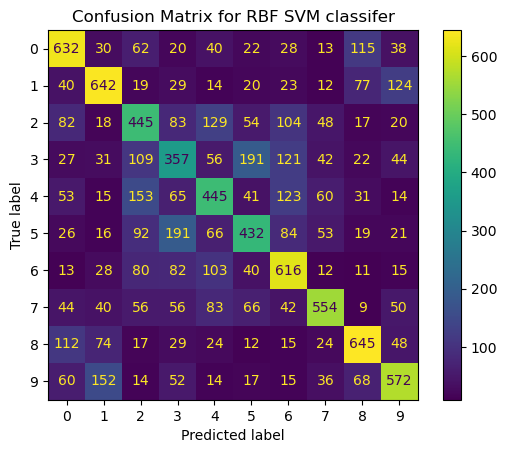

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_predicted, labels=final_svm_pipe.named_steps["svc"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_svm_pipe.named_steps["svc"].classes_)
disp.plot()
plt.title("Confusion Matrix for RBF SVM classifer")
plt.show()

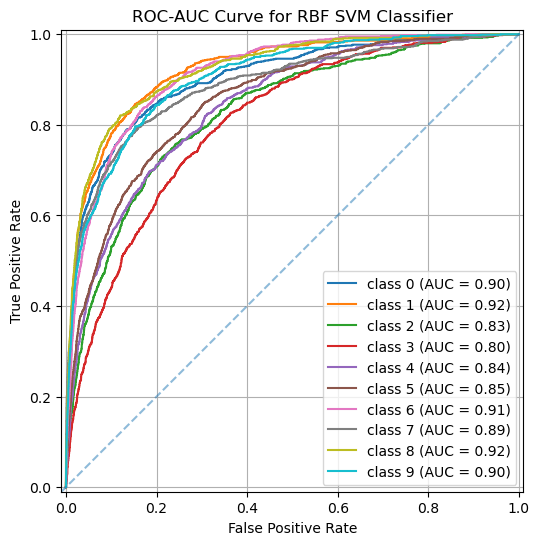

In [19]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

classes = final_svm_pipe.named_steps["svc"].classes_
y_score = final_svm_pipe.decision_function(X_test_svm)
y_test_bin = label_binarize(y_test, classes=classes)     

plt.figure(figsize=(7, 6))
for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"class {cls}",
        ax=plt.gca(),
    )
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.axline([0, 0], [1, 1], linestyle="--", alpha=0.5)
plt.title("ROC-AUC Curve for RBF SVM Classifier")
plt.grid()
plt.show()

#### Performative Analysis of MLP

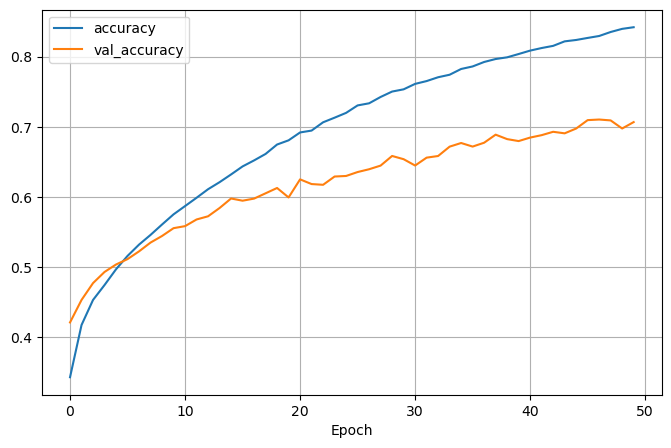

In [87]:
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.xlabel('Epoch')
plt.show()

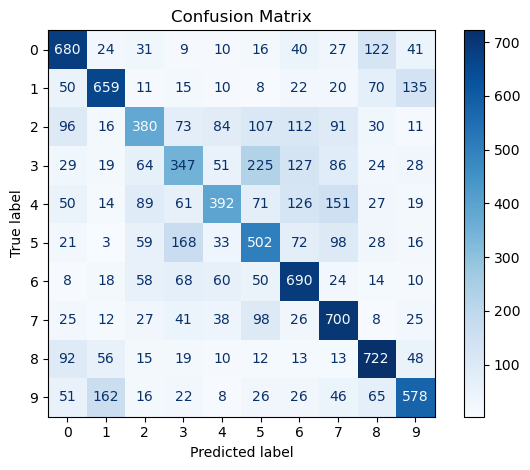

In [91]:
cm = confusion_matrix(y_test, y_pred)
conf_mat = ConfusionMatrixDisplay(confusion_matrix=cm)
conf_mat.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

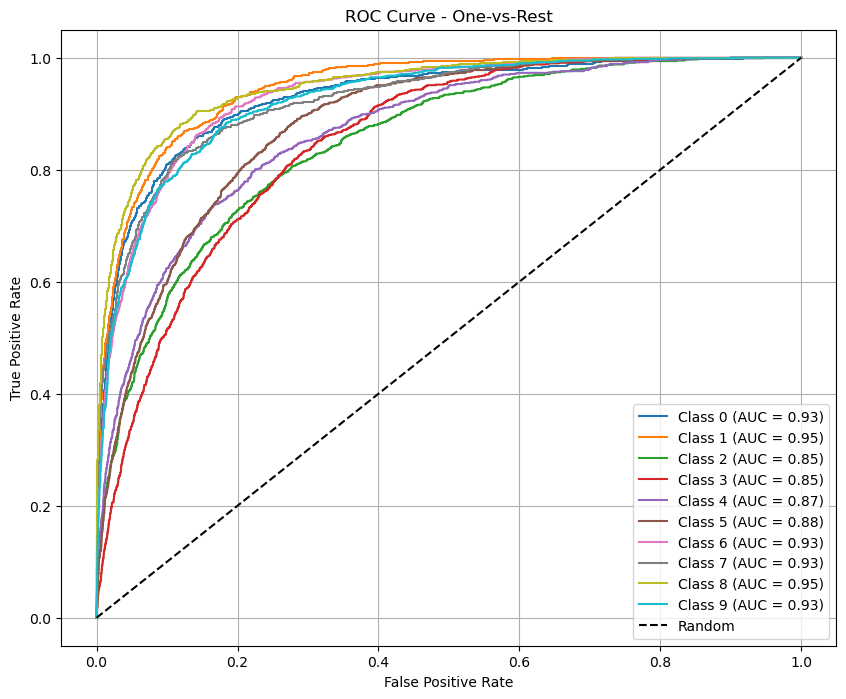

In [92]:
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=len(list(np.unique(y_test))))

plt.figure(figsize=(10,8))
for i in range(len(list(np.unique(y_test)))):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend()
plt.grid(True)
plt.show()